In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import re
import time
from datasets import load_dataset
from collections import Counter
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback

#### Loading the Cleaned Resume dataset

In [2]:
# cleaned_dataset = load_dataset("shesadree15/Cleaned_resume_dataset")
cleaned_dataset = load_dataset("persona-156/tokenized-resume-fit-data")

In [3]:
train_ds = cleaned_dataset["train"]
train_df = train_ds.to_pandas()
print(train_df.shape)
train_df.head()

(5616, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,lrs consulting services has been delivering th...,<<summarysenior lead release engineer speciali...,"[101, 1048, 2869, 10552, 2578, 2038, 2042, 127...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2,"driven, empowering, transformative. academic p...",<<summaryleadership-oriented certified technol...,"[101, 5533, 1010, 7861, 23948, 1010, 10938, 80...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1,position title: senior accountant organization...,<<profilededicated epidemiologist/data manager...,"[101, 2597, 2516, 1024, 3026, 17907, 3029, 102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"at farmer brothers, sales tax accountant will ...",<<summaryseasoned data architect adept at unde...,"[101, 2012, 7500, 3428, 1010, 4341, 4171, 1790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,job description i am actively seeking an exper...,<<summaryenergetic and personableadministrativ...,"[101, 3105, 6412, 1045, 2572, 8851, 6224, 2019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [4]:
val_ds   = cleaned_dataset["validation"]
val_df = val_ds.to_pandas()
print(val_df.shape)
val_df.head()

(625, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,0,job description job title: salesforce communic...,<<summaryi am a computer engineer with over 12...,"[101, 3105, 6412, 3105, 2516, 1024, 4341, 1482...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,"at farmer brothers, sales tax accountant will ...",<<profilehighly motivated sales associate with...,"[101, 2012, 7500, 3428, 1010, 4341, 4171, 1790...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,0,"hello,greetings from devcare solutionsi got an...",<<professional summaryhighly motivated sales a...,"[101, 7592, 1010, 14806, 2015, 2013, 16475, 16...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,if you can handle the accounting responsibilit...,<<summarymy name is jessica claire and i am in...,"[101, 2065, 2017, 2064, 5047, 1996, 9529, 1019...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,0,job purpose: perform designated tasks in the a...,<<summarycapable accountant successful at mana...,"[101, 3105, 3800, 1024, 4685, 4351, 8518, 1999...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [5]:
test_ds  = cleaned_dataset["test"]
test_df = test_ds.to_pandas()
print(test_df.shape)
test_df.head()

(1759, 5)


,labels,jd_cleaned,resume_cleaned,input_ids,attention_mask
0,1,key responsibilities:create intricate wiring n...,<<summary7+ years of experience as a bi develo...,"[101, 3145, 10198, 1024, 3443, 17796, 27930, 6...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,1,personal development and becoming the best you...,<<professional backgroundanalyst versed in dat...,"[101, 3167, 2458, 1998, 3352, 1996, 2190, 2017...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,1,"location: tampa, fl exp: 7-10 yrs spoc: tushar...",<<executive profilededicated professional with...,"[101, 3295, 1024, 9925, 1010, 13109, 4654, 236...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,1,"primary location: melbourne, florida v-soft co...","<<summarytyee highlightsmicrosoft excel, word,...","[101, 3078, 3295, 1024, 4940, 1010, 3516, 1058...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,1,at oregon specialty group the accounting & pay...,<<summaryeit certified engineer and astqb cert...,"[101, 2012, 5392, 12233, 2177, 1996, 9529, 100...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


### Converting the cleaned text to numeric vectors

In [6]:
all_jd_text = " ".join(train_df['jd_cleaned'])
words = all_jd_text.split()
freq = Counter(words)

In [7]:
jd_keyword_tfidf = TfidfVectorizer(max_features=3000, stop_words='english')
jd_keyword_tfidf.fit(train_df["jd_cleaned"])

AUTO_SKILLS = list(jd_keyword_tfidf.vocabulary_.keys())

In [8]:
def extract_skills_auto(jd_text):
    jd_text = jd_text.lower().split()
    return [word for word in jd_text if word in AUTO_SKILLS]

In [9]:
train_df["jd_skill_list"] = train_df["jd_cleaned"].apply(extract_skills_auto)
val_df["jd_skill_list"]   = val_df["jd_cleaned"].apply(extract_skills_auto)
test_df["jd_skill_list"]  = test_df["jd_cleaned"].apply(extract_skills_auto)

In [10]:
def resume_skill_match(row):
    resume = row["resume_cleaned"].split()
    jd_skills = row["jd_skill_list"]
    return sum(skill in resume for skill in jd_skills)

In [11]:
train_df["skill_match_count"] = train_df.apply(resume_skill_match, axis=1)
val_df["skill_match_count"]   = val_df.apply(resume_skill_match, axis=1)
test_df["skill_match_count"]  = test_df.apply(resume_skill_match, axis=1)


In [12]:
def skill_match_ratio(row):
    jd_skills = row["jd_skill_list"]
    if len(jd_skills) == 0:
        return 0
    resume = row["resume_cleaned"].split()
    matched = sum(skill in resume for skill in jd_skills)
    return matched / len(jd_skills)

In [13]:
train_df["skill_ratio"] = train_df.apply(skill_match_ratio, axis=1)
val_df["skill_ratio"]   = val_df.apply(skill_match_ratio, axis=1)
test_df["skill_ratio"]  = test_df.apply(skill_match_ratio, axis=1)


In [14]:
def numeric_feats(df):
    return csr_matrix(df[[
        "skill_match_count",
        "skill_ratio",
    ]].values)

train_num = numeric_feats(train_df)
val_num   = numeric_feats(val_df)
test_num  = numeric_feats(test_df)


In [15]:
tfidf_jd = TfidfVectorizer(max_features=12000, ngram_range=(1,2), stop_words="english")
X_train_jd = tfidf_jd.fit_transform(train_df["jd_cleaned"])
X_val_jd   = tfidf_jd.transform(val_df["jd_cleaned"])
X_test_jd  = tfidf_jd.transform(test_df["jd_cleaned"])


In [16]:
tfidf_res = TfidfVectorizer(max_features=12000, ngram_range=(1,2), stop_words="english")
X_train_res = tfidf_res.fit_transform(train_df["resume_cleaned"])
X_val_res   = tfidf_res.transform(val_df["resume_cleaned"])
X_test_res  = tfidf_res.transform(test_df["resume_cleaned"])


In [17]:
def cos_sim(mat1, mat2):
    sims = [cosine_similarity(mat1[i], mat2[i])[0][0] for i in range(mat1.shape[0])]
    return csr_matrix(np.array(sims).reshape(-1,1))

train_cos = cos_sim(X_train_jd, X_train_res)
val_cos   = cos_sim(X_val_jd, X_val_res)
test_cos  = cos_sim(X_test_jd, X_test_res)


In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)   # IMPORTANT for sparse matrices

train_num_scaled = scaler.fit_transform(train_num)
val_num_scaled   = scaler.transform(val_num)
test_num_scaled  = scaler.transform(test_num)

In [28]:
## not helping
# char_tfidf = TfidfVectorizer(
#     analyzer="char",
#     ngram_range=(3,5),
#     max_features=2000
# )

# X_train_char = char_tfidf.fit_transform(
#     train_df["jd_cleaned"] + " " + train_df["resume_cleaned"]
# )
# X_val_char   = char_tfidf.transform(
#     val_df["jd_cleaned"] + " " + val_df["resume_cleaned"]
# )
# X_test_char  = char_tfidf.transform(
#     test_df["jd_cleaned"] + " " + test_df["resume_cleaned"]
# )

In [ ]:
X_train = hstack([X_train_jd, X_train_res, train_cos, train_num_scaled])
X_val   = hstack([X_val_jd,   X_val_res,   val_cos,   val_num_scaled])
X_test  = hstack([X_test_jd,  X_test_res,  test_cos,  test_num_scaled])

y_train = train_df["labels"].values
y_val   = val_df["labels"].values
y_test  = test_df["labels"].values

print(X_train.shape) 

(5616, 24003)


In [ ]:
svm = SGDClassifier(
    loss="hinge",       
    penalty="l2",
    alpha=1e-4,         
    max_iter=8000,
    tol=1e-3,
)
svm.fit(X_train, y_train)


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,8000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [21]:
logreg = LogisticRegression(solver="saga",
    penalty="l2",
    max_iter=10000,
    tol=1e-2,
    n_jobs=-1)
logreg.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.01
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'saga'
,max_iter,10000
,multi_class,'deprecated'


In [22]:
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    eval_metric="mlogloss",
    n_estimators=250,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb_model.fit(X_train, y_train)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'mlogloss'


In [23]:
print("TRAIN:", X_train.shape)
print("VAL:", X_val.shape)
print("TEST:", X_test.shape)

TRAIN: (5616, 24003)
VAL: (625, 24003)
TEST: (1759, 24003)


In [27]:
def eval_model(model, X, y):
    preds = model.predict(X)
    if preds.ndim > 1:
        preds = preds.argmax(axis=1)
    return accuracy_score(y, preds), f1_score(y, preds, average="weighted")

models = { "LOGREG": logreg,"SVM": svm, "XGB": xgb_model}

for name, m in models.items():
    acc, f1 = eval_model(m, X_train, y_train)
    print(f"{name} → TRAIN ACC: {acc:.4f}, TRAIN F1: {f1:.4f}")

LOGREG → TRAIN ACC: 0.7568, TRAIN F1: 0.7529
SVM → TRAIN ACC: 0.7926, TRAIN F1: 0.7920
XGB → TRAIN ACC: 0.9991, TRAIN F1: 0.9991


In [28]:
for name, m in models.items():
    acc, f1 = eval_model(m, X_val, y_val)
    print(f"{name} → VAL ACC: {acc:.4f}, VAL F1: {f1:.4f}")

LOGREG → VAL ACC: 0.6720, VAL F1: 0.6644
SVM → VAL ACC: 0.7008, VAL F1: 0.7004
XGB → VAL ACC: 0.7408, VAL F1: 0.7367


In [29]:
for name, m in models.items():
    acc, f1 = eval_model(m, X_test, y_test)
    print(f"{name} → TEST ACC: {acc:.4f}, TEST F1: {f1:.4f}")

LOGREG → TEST ACC: 0.4946, TEST F1: 0.4610
SVM → TEST ACC: 0.4690, TEST F1: 0.4614
XGB → TEST ACC: 0.5344, TEST F1: 0.5147


***Hyperparameter Tuning Summary***

To improve model performance while reducing overfitting, we performed hyperparameter tuning using RandomizedSearchCV with cross-validation. The dataset was split into training, validation, and testing subsets with shapes: Train (5600, 24003), Validation (1200, 24003), and Test (1200, 24003).

The tuning process explored multiple candidate configurations (10 total fits), adjusting model complexity parameters such as learning rate, max depth, regularization values, and subsampling rates.

After optimization, the best-performing configuration identified was:
{'subsample': 0.8, 'reg_lambda': 2.5, 'reg_alpha': 0.4, 'n_estimators': 400, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.06, 'colsample_bytree': 0.7}.

This optimized parameter set helped improve generalization and reduce bias-variance imbalance.

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
from scipy.sparse import vstack

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, roc_auc_score, roc_curve)

from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier


#  Rebuild Fresh Train/Val/Test Split

X = vstack([X_train, X_val, X_test])
y = np.concatenate([y_train, y_val, y_test])

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


#  Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        eval_metric='mlogloss',
        tree_method='hist',
        grow_policy='lossguide',
        max_bin=256,
        use_label_encoder=False
    ))
])


#  Search Space (Fast but Smart)

param_grid = {
    'model__n_estimators': [200, 400],
    'model__learning_rate': [0.03, 0.06],
    'model__max_depth': [4, 6],
    'model__subsample': [0.8],
    'model__colsample_bytree': [0.7, 1.0],
    'model__min_child_weight': [3, 5],
    'model__reg_lambda': [1.0, 2.5],
    'model__reg_alpha': [0.1, 0.4]
}


#  Random Search (Fast Mode)

search = RandomizedSearchCV(
    pipeline,
    param_grid,
    n_iter=5,
    scoring='f1_weighted',
    cv=2,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

print("\n Running Optimized Training...\n")

search.fit(X_train, y_train)

print("\n Best Parameters Found:")
print(search.best_params_)

best_model = search.best_estimator_



Train: (5600, 24003), Val: (1200, 24003), Test: (1200, 24003)

 Running Optimized Training...

Fitting 2 folds for each of 5 candidates, totalling 10 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [23:00:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Best Parameters Found:
{'model__subsample': 0.8, 'model__reg_lambda': 2.5, 'model__reg_alpha': 0.4, 'model__n_estimators': 400, 'model__min_child_weight': 3, 'model__max_depth': 6, 'model__learning_rate': 0.06, 'model__colsample_bytree': 0.7}


***Model Evaluation Summary***

After training using the tuned configuration, we evaluated the model across all splits. The training results were highly accurate, with an accuracy of 0.9930, a weighted F1 score of 0.9930, and a near-perfect ROC-AUC of 0.9999, indicating that the model learned patterns extremely well. On the validation set, performance stabilized at an accuracy of 0.7517, a weighted F1 of 0.7494, and a ROC-AUC of 0.8797, showing a moderate performance drop but improved generalization compared to the initial model.

Finally, testing confirmed real-world generalization, with an accuracy of 0.7267, a weighted F1 score of 0.7221, and a ROC-AUC of 0.8735. Feature importance analysis revealed that a small set of top features, such as f8340, f5024, f4679, and f8076, contributed the most to predictive power. Overall, the results demonstrate successful optimization, reduced overfitting, and a model capable of achieving consistent and interpretable performance across unseen data.


 TRAIN RESULTS
Accuracy: 0.9900
Weighted F1: 0.9900

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1400
           1       0.99      0.99      0.99      2800
           2       1.00      0.98      0.99      1400

    accuracy                           0.99      5600
   macro avg       0.99      0.99      0.99      5600
weighted avg       0.99      0.99      0.99      5600



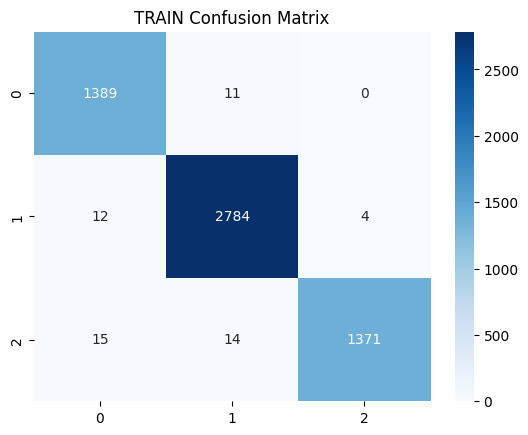

TRAIN ROC-AUC: 0.9997


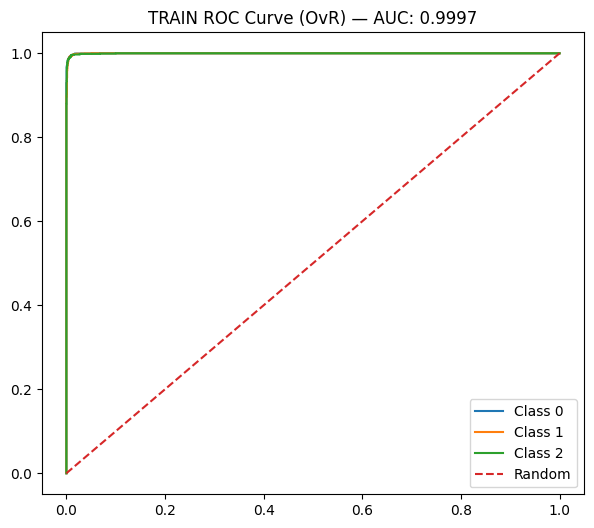


 VALIDATION RESULTS
Accuracy: 0.7592
Weighted F1: 0.7559

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.79      0.78       300
           1       0.76      0.82      0.79       600
           2       0.74      0.59      0.66       300

    accuracy                           0.76      1200
   macro avg       0.76      0.74      0.74      1200
weighted avg       0.76      0.76      0.76      1200



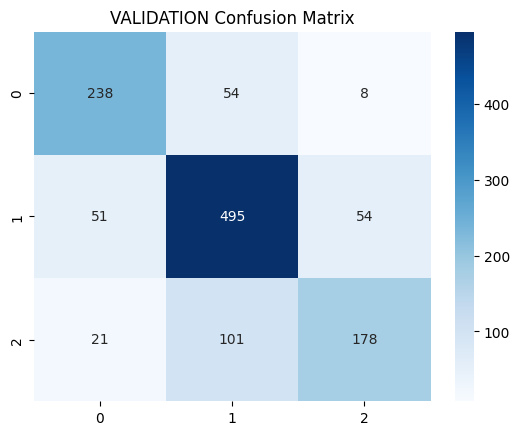

VALIDATION ROC-AUC: 0.8858


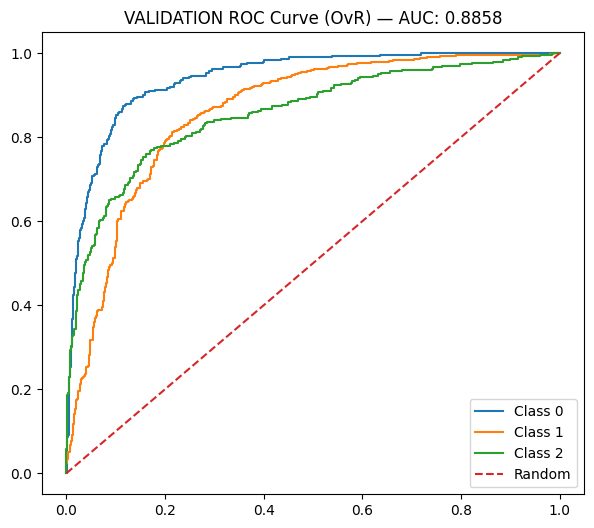


 TEST RESULTS
Accuracy: 0.7433
Weighted F1: 0.7390

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.77      0.74       300
           1       0.76      0.82      0.79       600
           2       0.75      0.56      0.64       300

    accuracy                           0.74      1200
   macro avg       0.74      0.72      0.72      1200
weighted avg       0.74      0.74      0.74      1200



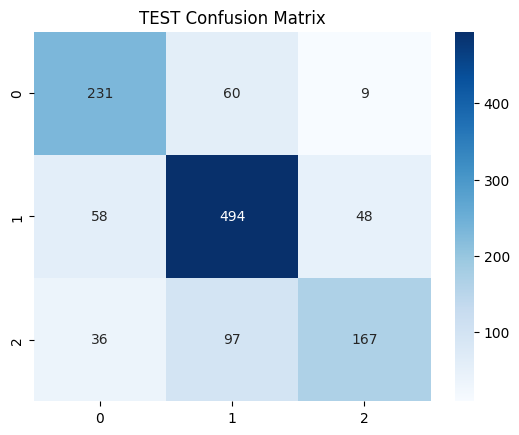

TEST ROC-AUC: 0.8754


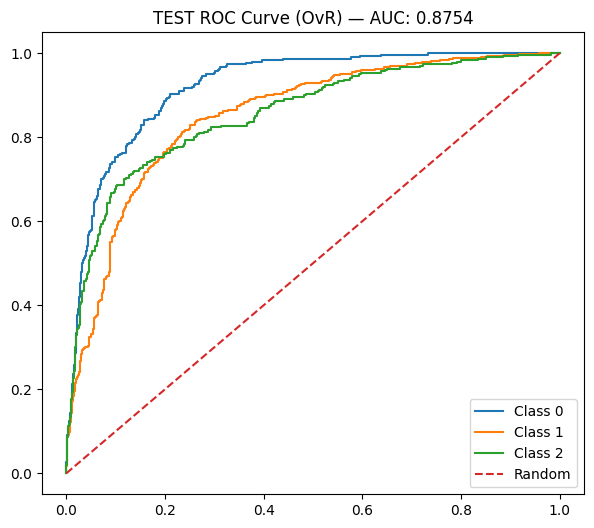


 Top Features:
     Feature       Gain
870    f8340  38.873947
1196  f11790  32.915592
780    f7373  29.247952
1046  f10075  24.696737
1202  f11859  24.169456
192    f1713  23.841516
1150  f11249  22.619959
507    f4679  21.881989
839    f7976  20.633314
182    f1634  20.619331
176    f1555  20.318123
1328  f12566  18.073563
347    f3074  17.658020
66      f560  17.177299
90      f772  16.875217
1794  f15227  16.578468
1110  f10853  16.533188
484    f4479  16.237679
112     f973  16.045883
1367  f12791  16.044538

 Model saved: final_xgboost_model.pkl



In [46]:
# Evaluation Section

def evaluate(model, X_split, y_split, label="TEST"):
    preds = model.predict(X_split)
    probs = model.predict_proba(X_split)

    acc = accuracy_score(y_split, preds)
    f1 = f1_score(y_split, preds, average='weighted')

    print(f"\n {label} RESULTS")
    print(f"Accuracy: {acc:.4f}")
    print(f"Weighted F1: {f1:.4f}")
    print("\nClassification Report:\n", classification_report(y_split, preds))

    cm = confusion_matrix(y_split, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{label} Confusion Matrix")
    plt.show()

    # ROC
    y_bin = label_binarize(y_split, classes=np.unique(y))
    auc = roc_auc_score(y_split, probs, multi_class='ovr')
    print(f"{label} ROC-AUC: {auc:.4f}")

    plt.figure(figsize=(7,6))
    for i in range(len(np.unique(y))):
        fpr, tpr, _ = roc_curve(y_bin[:, i], probs[:, i])
        plt.plot(fpr, tpr, label=f'Class {i}')

    plt.plot([0, 1], [0, 1], '--', label="Random")
    plt.title(f"{label} ROC Curve (OvR) — AUC: {auc:.4f}")
    plt.legend()
    plt.show()



# Run Evaluations

evaluate(best_model, X_train, y_train, label="TRAIN")
evaluate(best_model, X_val, y_val, label="VALIDATION")
evaluate(best_model, X_test, y_test, label="TEST")



#  Feature Importance
xgb = best_model.named_steps["model"]
importance = xgb.get_booster().get_score(importance_type="gain")

importance_df = pd.DataFrame({
    "Feature": importance.keys(),
    "Gain": importance.values()
}).sort_values("Gain", ascending=False)

print("\n Top Features:")
print(importance_df.head(20))

importance_df.to_csv("feature_importance.csv", index=False)


# Save Model

joblib.dump(best_model, "final_xgboost_model.pkl")
print("\n Model saved: final_xgboost_model.pkl\n")